In [1]:
import sys
import os

In [2]:

root_list = ["/data_preprocessing/", "/TARN_MAPPO"]
for root in root_list:
    sys.path.append(os.getcwd() + root)
sys.path.append(os.getcwd())

In [3]:
sys.path

['/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/data_preprocessing/',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock']

In [21]:
%load_ext autoreload
%autoreload 2
# root_list = ["/data_preprocessing", "/TARN_PPO"]
# for root in root_list:
#     sys.path.append(os.getcwd() + root)
# sys.path.append('/workspace')
# os.chdir('/workspace')
import pandas as pd
import numpy as np
# from data_preprocessing.preprocessing_config import *
# from preprocessing_config import *
# from utils import *
# root_list = ["/data_preprocessing", "/TARN_MAPPO"]
# for root in root_list:
#     sys.path.append(os.getcwd() + root)
# sys.path.append('/workspace')
# os.chdir('/workspace')
import dynamic_portfolio as dp
import data_preprocessing.technical_indicators as ti
import data_preprocessing.main_preprocessing as preprop
from TARN_MAPPO.run import *
from TARN_MAPPO.agent import PPO
import copy
from TARN_PPO.enviroment import EnvConfig, Stock_Env
import TARN_PPO.backtesting as backtest
# import wandb
import pickle
import random
import copy

import torch
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def set_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # Multi-GPU 환경 고려
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
set_seed(SEED)

Random seed set to: 42


## 벤치마크 데이터


- 각 포트폴리오 수익률
- S&P 500 수익률

In [23]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2021-01-01'
TRADE_END_DATE = '2023-12-31'

In [24]:
test_scaled_data_path = "./data/test_daily_v4.pkl"
test_dataset_path = "data/test_v4.csv"
test_scaled_tensor_path = "data/test_daily_data_v4.pt"

with open(test_scaled_data_path, "rb") as f:
    test_data = pickle.load(f)
    
test_dataset = pd.read_csv(test_dataset_path, index_col=0)
test_dataset.set_index("date", inplace=True)


test_scaled_tensor = torch.load(test_scaled_tensor_path)
test_scaled_tensor = test_scaled_tensor

feature_dim = 15


In [25]:
test_scaled_tensor.shape

torch.Size([1259, 20, 84, 15])

In [26]:
test_dataset.index.unique()

Index(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08',
       '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15',
       ...
       '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
       '2023-12-22', '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29'],
      dtype='object', name='date', length=1258)

In [27]:
test_scaled_tensor.shape

torch.Size([1259, 20, 84, 15])

In [28]:
test_dataset = test_dataset[(test_dataset.index > TRADE_START_DATE) &(test_dataset.index < TRADE_END_DATE)]


In [29]:
def get_hyperparameters(feature_dim):
    return {
        "dcc_dropout": 0.2,
        "sac_dropout": 0.01,
        "sac_heads": 2,
        "ddc_configs": [
            {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
            {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
            {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
        ],
        "final_conv_config": {"in_channels" : 16, "out_channels": 8, "kernel_size": 20, "stride": 1, "padding": 0}
    }
hyperparameters = get_hyperparameters(feature_dim)

In [30]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xticks(cumulative_returns.index[::int(len(cumulative_returns.index)/20)], rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()



In [31]:


import yfinance as yf
dji = yf.download("^ndx", start=TRADE_START_DATE, end=TRADE_END_DATE)
dji.columns = dji.columns.get_level_values(0)
dji=dji.reset_index()
dji.sort_values(by='Date', inplace=True)
dji.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace = True)
df_dji = dji[["date", "close"]]
fst_day = df_dji["close"][0]


dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

dji.rename(columns={"close": "dji"}, inplace=True)

dji.index = pd.to_datetime(dji.index).strftime("%Y-%m-%d")

[*********************100%***********************]  1 of 1 completed


In [32]:
test_dataset.tic.nunique()

84

In [33]:
model_path = "/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]

In [34]:
model = "scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5_TARN_mappo_model.pth"

config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
env_test = Stock_Env(config)
config.save_path = model_path + "/" + model

AttributeError: 'Stock_Env' object has no attribute 'days'

In [35]:
agent = PPO(config)
agent.load()
rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)

FileNotFoundError: [Errno 2] No such file or directory: './TARN_PPO/model/actor_lr0.0003_critic_lr0.001_gamma0.999_epochs1000_update20_eps_clip0.2_ppo_model_.pth'

In [121]:
dji.rename(columns={"dji": "nasdaq"}, inplace=True)

In [122]:
asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
empty_df.rename(columns={"invest": "model"}, inplace=True)
tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
tot_data = pd.concat([tot_data, dji], axis=1)

In [123]:
return_df = tot_data.pct_change().fillna(0)

In [124]:
cum_ret_df = (1+return_df).cumprod()-1

In [125]:
log_return = np.log(return_df+1)

In [126]:
cum_log= log_return.cumsum()

In [127]:
import matplotlib.pyplot as plt

%matplotlib inline

In [128]:
cum_ret_df

,model,GTAA,DM,PAA,DAA,Sentiment,risk,n_weight,nasdaq
date,,,,,,,,,
2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.011202,0.011716,0.016501,0.019201,0.018029,0.005389,0.007480,0.013053,0.008485
2021-01-06,0.005707,-0.003180,0.015653,0.010698,0.019353,0.004648,0.009550,0.009454,-0.005617
2021-01-07,0.042331,0.032668,0.058697,0.055175,0.059679,0.035628,0.021718,0.043927,0.019292
2021-01-08,0.055550,0.042883,0.079558,0.070705,0.078127,0.044207,0.031128,0.057768,0.032340
...,...,...,...,...,...,...,...,...,...
2023-12-22,0.693903,0.756815,0.506294,0.318078,0.243974,0.744831,0.652722,0.559077,0.321611
2023-12-26,0.713462,0.776737,0.522050,0.326231,0.257705,0.767149,0.670327,0.575337,0.329572
2023-12-27,0.715186,0.780542,0.524021,0.328094,0.260272,0.766464,0.671479,0.577215,0.331804


In [129]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(save_cum, item):
    plt.figure(figsize=(20, 10))

    # 확연히 구분되는 20개 색상 설정 (tab20 컬러맵 활용)
    cmap = plt.get_cmap("tab20")
    num_colors = len(save_cum.columns)
    colors = [cmap(i % 20) for i in range(num_colors)]

    for i, category in enumerate(save_cum.columns):
        if category in ["model", "n_weight", "TARN_MAPPO", "nasdaq", "S&P 500 Index"]:
        
            plt.plot(
                save_cum.index, save_cum[category],
                label=category, color=colors[i], linewidth=1.5  # linestyle 제거
            )

        else:
            plt.plot(
                save_cum.index, save_cum[category],
                label=category, color=colors[i],
                # linestyle = "--"
            )
        # 개별 legend 추가 (각 라인 끝 위치에 표시)
        plt.text(
            save_cum.index[-1], save_cum[category].iloc[-1], category, 
            fontsize=9, color=colors[i], verticalalignment='center'
        )

    # 그래프 제목 추가
    plt.title(f'{item} Over Time', fontsize=20)

    # X축 눈금 조정 (22개 간격으로 표시)
    plt.xlabel('Date', fontsize=15)
    plt.xticks(save_cum.index[::20], rotation=45)

    # Y축 라벨 추가
    plt.ylabel(f'{item}', fontsize=15)

    # 격자 추가
    plt.grid(alpha=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()


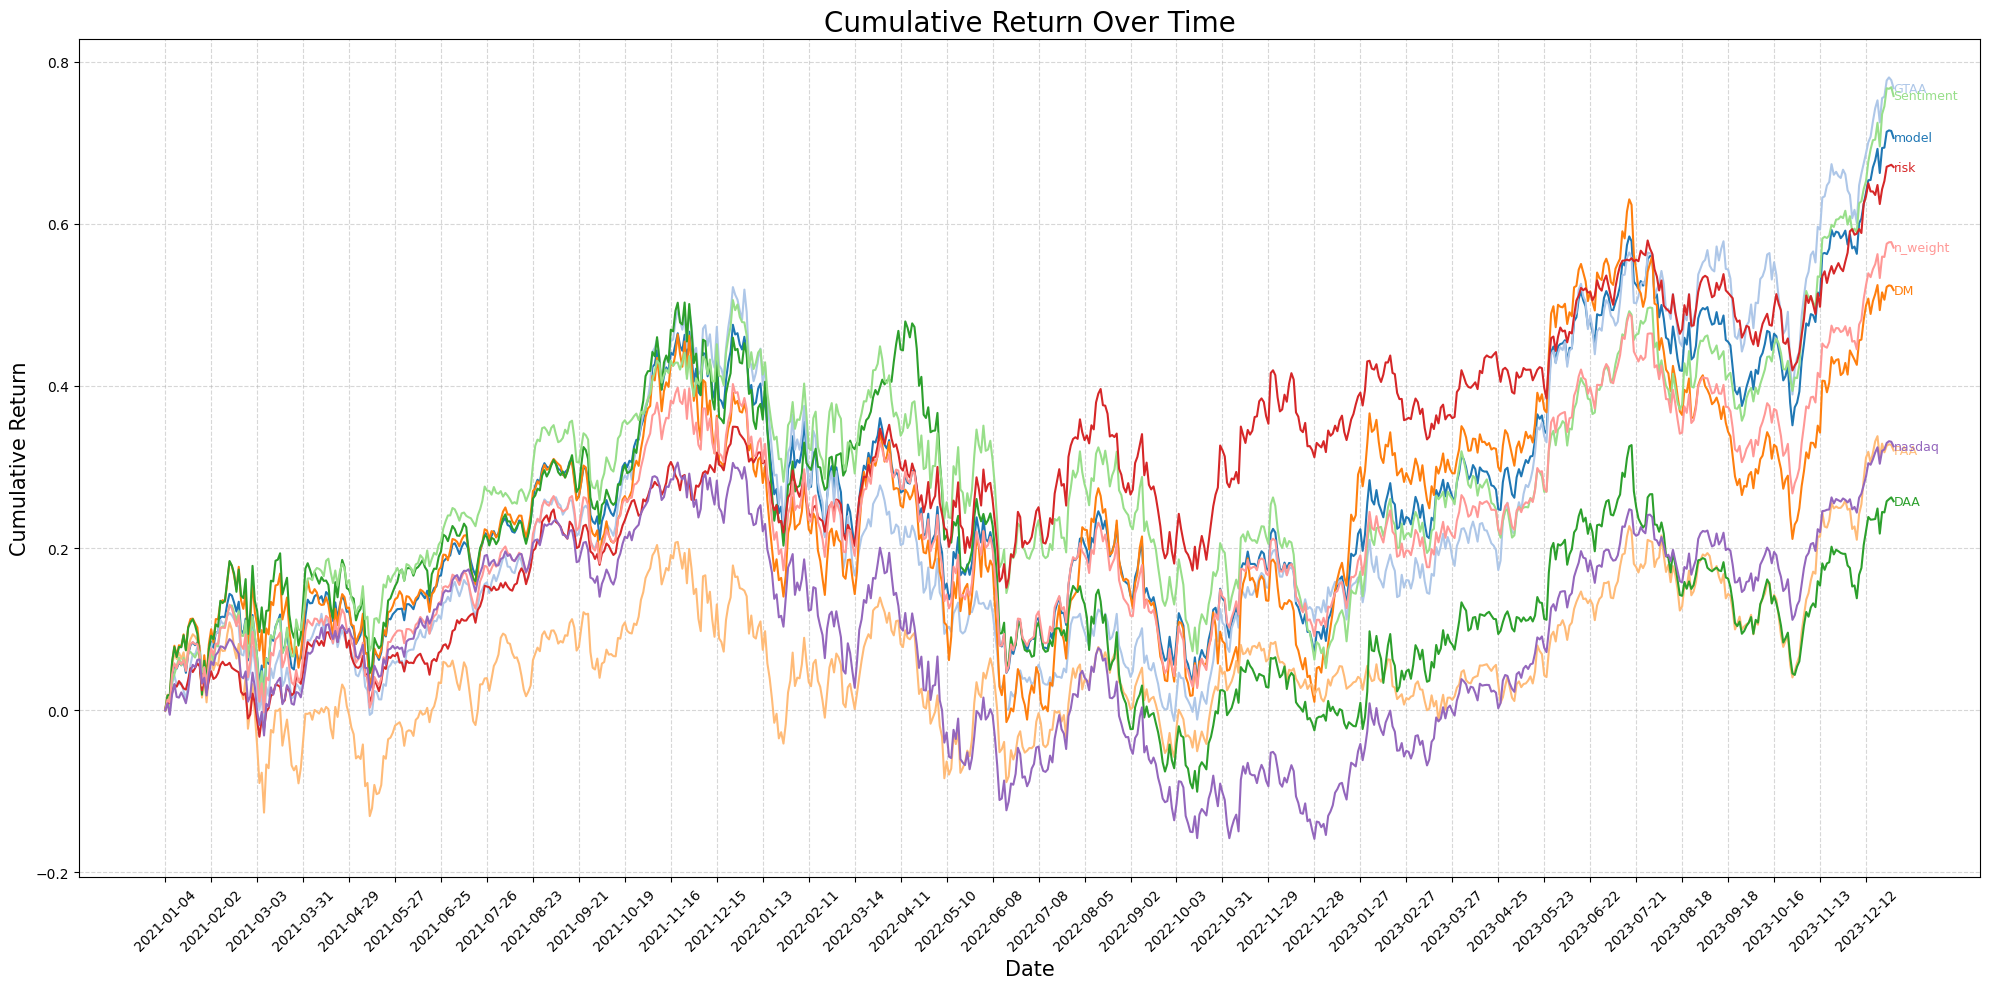

In [130]:
visualize_data(cum_ret_df, "Cumulative Return")

In [131]:
def eval_result(return_df):
    cal_eval = pd.DataFrame()
    for col in return_df.columns:
        save_eval = {}
        sharpe = backtest.calculate_sharpe_ratio(return_df[col], risk_free_rate=0.0, annual_factor=252)
        sortino = backtest.calculate_annualized_sortino_ratio(return_df[col], risk_free_rate=0.0, annual_factor=252)
        max_drawdown = backtest.calculate_max_drawdown(return_df[col])
        cagr = backtest.calculate_cagr(return_df[col], annual_factor=252) * 100
        cumulative_return = backtest.calculate_cumulative_return(return_df[col]) *100
        save_eval[col] = [cagr, cumulative_return, sharpe, max_drawdown, sortino]
        cal_eval = pd.concat([cal_eval, pd.DataFrame(save_eval)], axis=1)
    cal_eval = cal_eval.T
    cal_eval.columns = ["CAGR", "Cumulative Return",  "Sharpe Ratio", "Max Drawdown", "Sortino Ratio"]
    
    return cal_eval

In [ ]:
return_df

,model,GTAA,DM,PAA,DAA,Sentiment,risk,n_weight,nasdaq
date,,,,,,,,,
2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.011202,0.011716,0.016501,0.019201,0.018029,0.005389,0.007480,0.013053,0.008485
2021-01-06,-0.005434,-0.014723,-0.000834,-0.008343,0.001301,-0.000737,0.002054,-0.003552,-0.013984
2021-01-07,0.036416,0.035962,0.042381,0.044006,0.039560,0.030837,0.012053,0.034151,0.025050
2021-01-08,0.012681,0.009893,0.019704,0.014718,0.017410,0.008284,0.009210,0.013258,0.012800
...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000236,0.001025,-0.006009,-0.008082,-0.000429,0.005502,0.006141,-0.000298,0.001193
2023-12-26,0.011547,0.011340,0.010460,0.006186,0.011038,0.012791,0.010652,0.010429,0.006024
2023-12-27,0.001006,0.002141,0.001295,0.001404,0.002041,-0.000388,0.000690,0.001192,0.001679


In [133]:
eval_score = eval_result(return_df)

In [134]:
eval_score


,CAGR,Cumulative Return,Sharpe Ratio,Max Drawdown,Sortino Ratio
model,19.569392,70.583106,0.722956,29.792118,1.097263
GTAA,20.993424,76.725836,0.771633,35.167485,1.152789
DM,14.995312,51.816168,0.472690,32.679123,0.742727
PAA,9.748336,32.042248,0.340904,24.542547,0.481617
DAA,7.976110,25.772667,0.289722,40.152030,0.419217
Sentiment,20.771952,75.760982,0.781647,30.141202,1.179341
risk,18.722829,66.999589,0.908283,16.031061,1.458867
n_weight,16.309957,57.061425,0.648443,26.740093,0.962877
nasdaq,9.887550,32.543365,0.392162,35.563140,0.577408


scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/low_risk_top10/scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5_TARN_mappo_model.pth loaded.
Day: 2021-01-04 ~ 2021-02-01
Day: 2021-02-02 ~ 2021-03-02
Day: 2021-03-03 ~ 2021-03-30
Day: 2021-03-31 ~ 2021-04-28
Day: 2021-04-29 ~ 2021-05-26
Day: 2021-05-27 ~ 2021-06-24
Day: 2021-06-25 ~ 2021-07-23
Day: 2021-07-26 ~ 2021-08-20
Day: 2021-08-23 ~ 2021-09-20
Day: 2021-09-21 ~ 2021-10-18
Day: 2021-10-19 ~ 2021-11-15
Day: 2021-11-16 ~ 2021-12-14
Day: 2021-12-15 ~ 2022-01-12
Day: 2022-01-13 ~ 2022-02-10
Day: 2022-02-11 ~ 2022-03-11
Day: 2022-03-14 ~ 2022-04-08
Day: 2022-04-11 ~ 2022-05-09
Day: 2022-05-10 ~ 2022-06-07
Day: 2022-06-08 ~ 2022-07-07
Day: 2022-07-08 ~ 2022-08-04
Day: 2022-08-05 ~ 2022-09-01
Day: 2022-09-02 ~ 2022-09-30
Day: 2022-10-03 ~ 2022-10-2

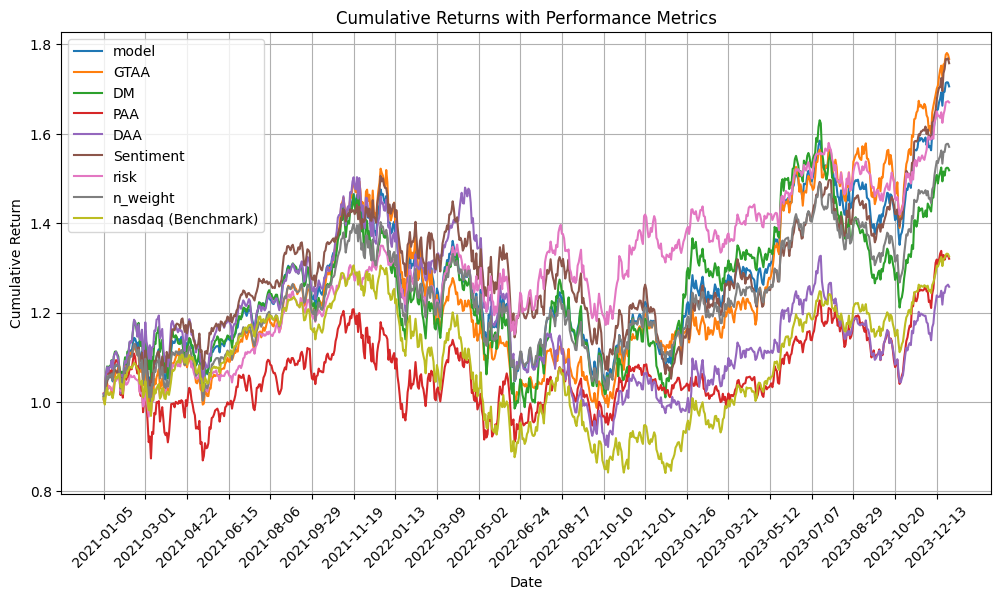

model Metrics:
  Information Ratio: 0.0643
  CVaR: -0.0345
  Rachev Ratio: 0.9653
GTAA Metrics:
  Information Ratio: 0.0513
  CVaR: -0.0346
  Rachev Ratio: 0.9746
DM Metrics:
  Information Ratio: 0.0273
  CVaR: -0.0402
  Rachev Ratio: 1.0271
PAA Metrics:
  Information Ratio: 0.0028
  CVaR: -0.0401
  Rachev Ratio: 0.9171
DAA Metrics:
  Information Ratio: -0.0045
  CVaR: -0.0376
  Rachev Ratio: 0.9559
Sentiment Metrics:
  Information Ratio: 0.0570
  CVaR: -0.0334
  Rachev Ratio: 0.9938
risk Metrics:
  Information Ratio: 0.0333
  CVaR: -0.0251
  Rachev Ratio: 1.0896
n_weight Metrics:
  Information Ratio: 0.0380
  CVaR: -0.0328
  Rachev Ratio: 0.9370


In [135]:
# model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/low_risk_top10"
# # all_files_and_folders = os.listdir(model_path)
# filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# # config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# # env_ex = Stock_Env(config_ex)
# # set_seed(SEED)




config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
env_test = Stock_Env(config)
config.save_path = model_path + "/" + model
print(model)
agent = PPO(config)
agent.load()
rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
empty_df.rename(columns={"invest": "model"}, inplace=True)
tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
tot_data = pd.concat([tot_data, dji], axis=1)
tot_data.to_csv("tot_data.csv")
# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "nasdaq"
metrics = compute_metrics(tot_data, strategies, benchmark)
plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
Day: 2019-01-31 ~ 2019-02-28
Day: 2019-03-01 ~ 2019-03-28
Day: 2019-03-29 ~ 2019-04-26
Day: 2019-04-29 ~ 2019-05-24
Day: 2019-05-28 ~ 2019-06-24
Day: 2019-06-25 ~ 2019-07-23
Day: 2019-07-24 ~ 2019-08-20
Day: 2019-08-21 ~ 2019-09-18
Day: 2019-09-19 ~ 2019-10-16
Day: 2019-10-17 ~ 2019-11-13
Day: 2019-11-14 ~ 2019-12-12
Day: 2019-12-13 ~ 2020-01-13
Day: 2020-01-14 ~ 2020-02-11
Day: 2020-02-12 ~ 2020-03-11
Day: 2020-03-12 ~ 2020-04-08
Day: 2020-04-09 ~ 2020-05-07
Day: 2020-05-08 ~ 2020-06-05
Day: 2020-06-08 ~ 2020-07-06
Day: 2020-07-07 ~ 2020-08-03
Day: 2020-08-04 ~ 2020-08-31
Day: 2020-09-01 ~ 2020-

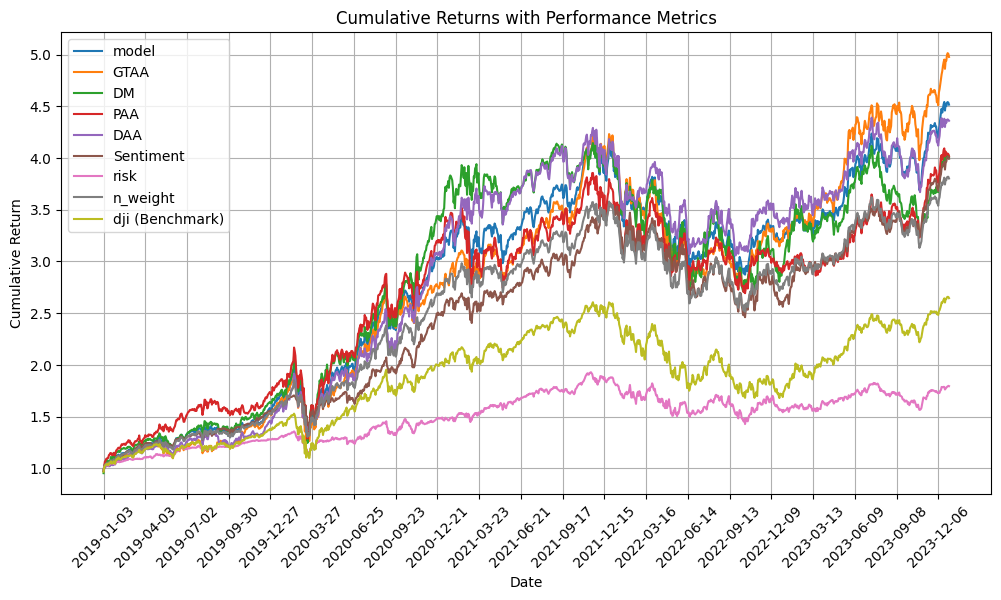

model Metrics:
  Information Ratio: 0.0568
  CVaR: -0.0419
  Rachev Ratio: 0.9067
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo

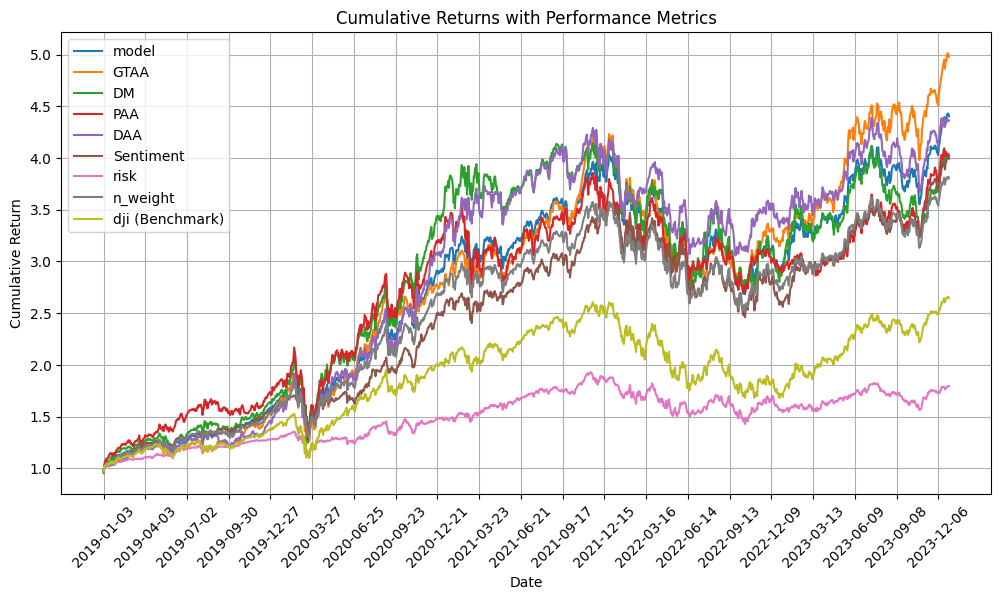

model Metrics:
  Information Ratio: 0.0750
  CVaR: -0.0388
  Rachev Ratio: 0.9323
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_map

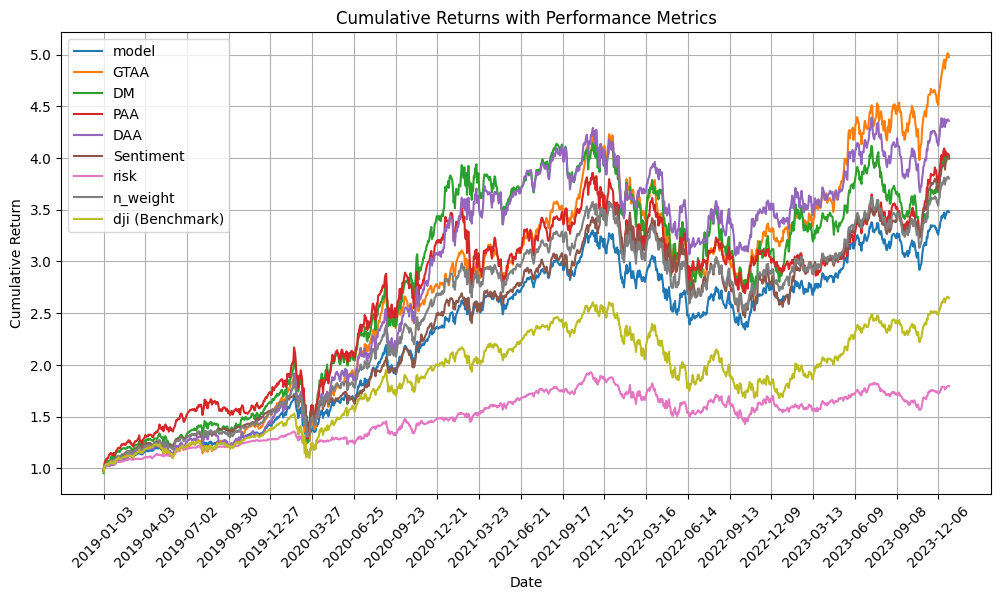

model Metrics:
  Information Ratio: 0.0290
  CVaR: -0.0339
  Rachev Ratio: 0.8918
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_2_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_m

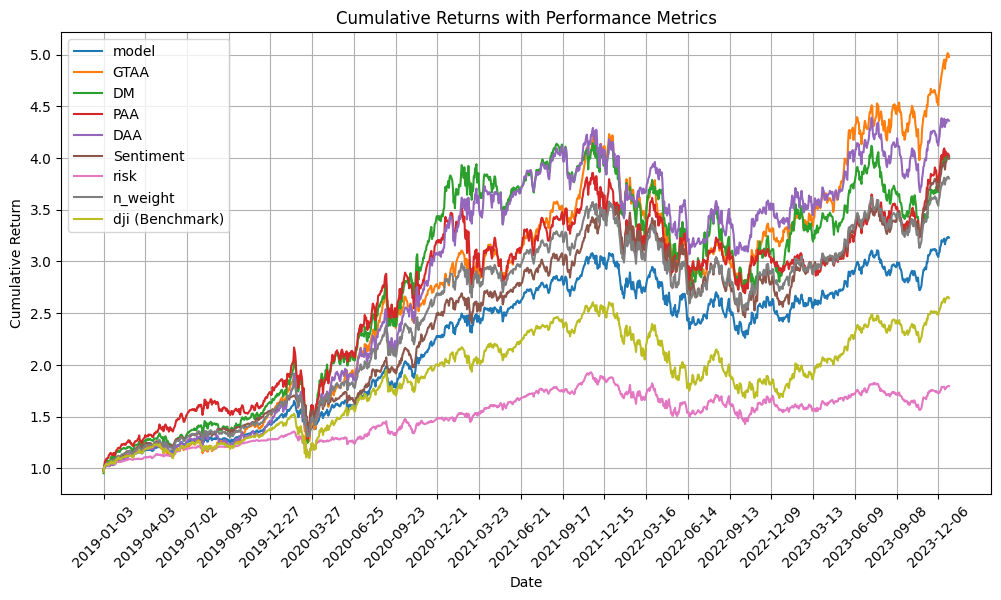

model Metrics:
  Information Ratio: 0.0163
  CVaR: -0.0309
  Rachev Ratio: 0.9232
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.2_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.2_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_m

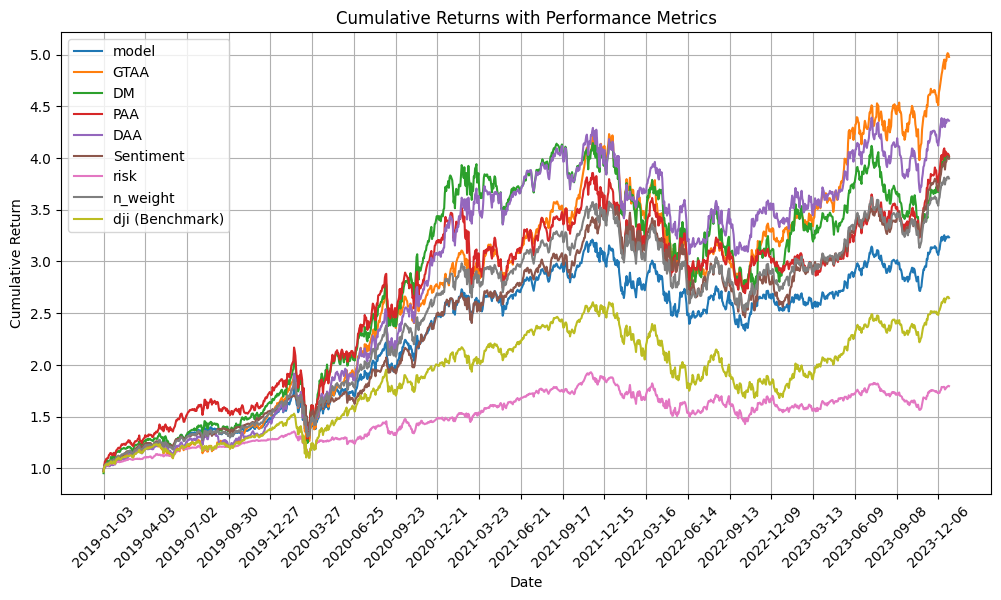

model Metrics:
  Information Ratio: 0.0189
  CVaR: -0.0356
  Rachev Ratio: 0.9153
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.2_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.2_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo

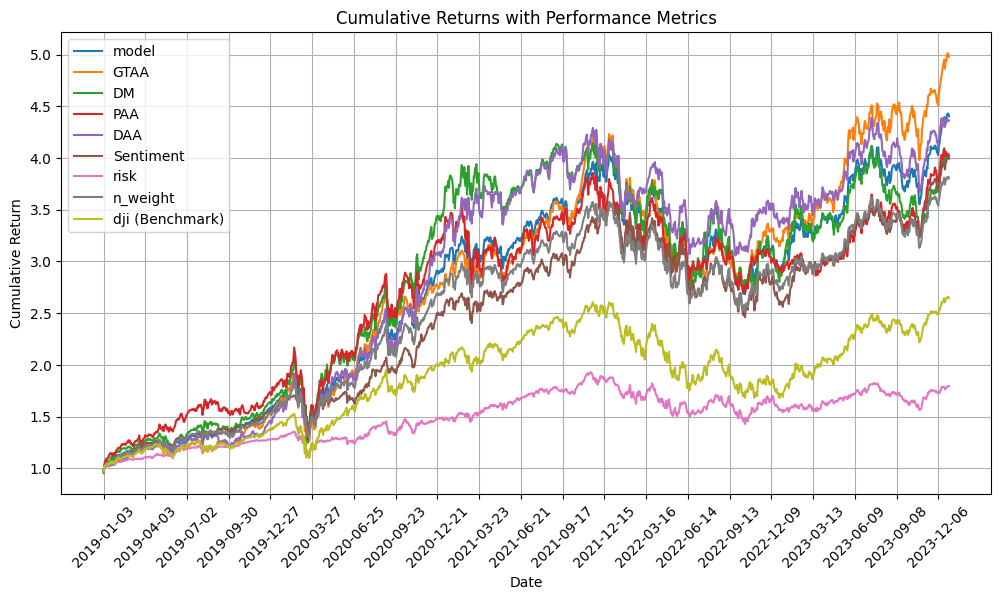

model Metrics:
  Information Ratio: 0.0750
  CVaR: -0.0388
  Rachev Ratio: 0.9323
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_map

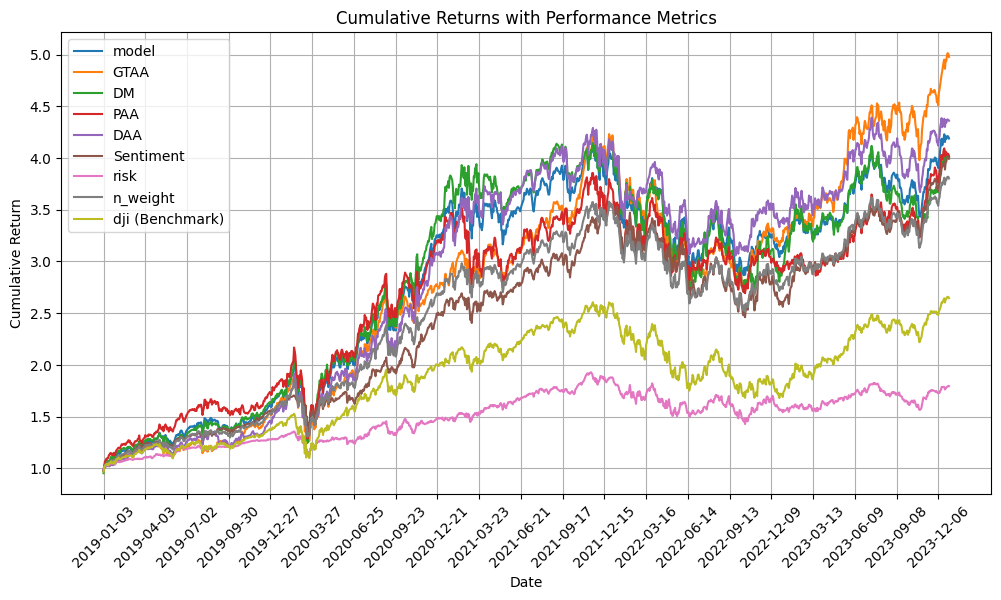

model Metrics:
  Information Ratio: 0.0460
  CVaR: -0.0432
  Rachev Ratio: 0.9365
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.01_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.5__k_epoch15_TARN_mappo_m

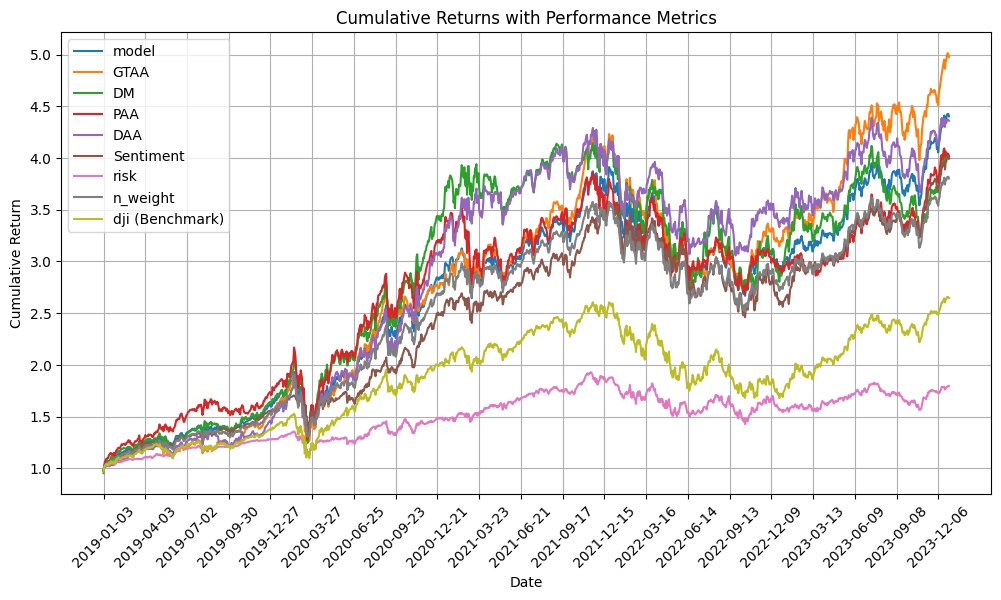

model Metrics:
  Information Ratio: 0.0672
  CVaR: -0.0394
  Rachev Ratio: 0.9122
GTAA Metrics:
  Information Ratio: 0.0747
  CVaR: -0.0421
  Rachev Ratio: 0.9043
DM Metrics:
  Information Ratio: 0.0403
  CVaR: -0.0467
  Rachev Ratio: 0.9928
PAA Metrics:
  Information Ratio: 0.0382
  CVaR: -0.0477
  Rachev Ratio: 0.9380
DAA Metrics:
  Information Ratio: 0.0379
  CVaR: -0.0405
  Rachev Ratio: 0.9427
Sentiment Metrics:
  Information Ratio: 0.0396
  CVaR: -0.0341
  Rachev Ratio: 0.9660
risk Metrics:
  Information Ratio: -0.0429
  CVaR: -0.0262
  Rachev Ratio: 0.9637
n_weight Metrics:
  Information Ratio: 0.0466
  CVaR: -0.0368
  Rachev Ratio: 0.9155
high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.1_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo_model.pth
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/high_risk_scaled_data_actor_num_agent_4_lr0.001_critic_lr0.1_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5__k_epoch15_TARN_mappo

In [ ]:

# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
# set_seed(SEED)



for model in filtered_items:

    config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
    env_test = Stock_Env(config)
    config.save_path = model_path + "/" + model
    print(model)
    agent = PPO(config)
    agent.load()
    rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
    asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
    empty_df.rename(columns={"invest": "model"}, inplace=True)
    tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
    tot_data = pd.concat([tot_data, dji], axis=1)
    tot_data.to_csv("tot_data.csv")
    # Example Usage
    # Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
    strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
    #strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
    benchmark = "dji"
    metrics = compute_metrics(tot_data, strategies, benchmark)
    plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

    # Print metrics
    for strategy, strategy_metrics in metrics.items():
        print(f"{strategy} Metrics:")
        for metric_name, value in strategy_metrics.items():
            print(f"  {metric_name}: {value:.4f}")

In [59]:
tot_data.columns

Index(['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight',
       'dji'],
      dtype='object')

In [ ]:
strategies = [
"PPO 100 epochs",
"CPPO 100 epochs",
"PPO-DeepSeek 100 epochs",
#"PPO-Llama 100 epochs",
"CPPO-DeepSeek 100 epochs"
#"CPPO-Llama 100 epochs",
]
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result, strategies, benchmark)
plot_cumulative_returns(result, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

,model,GTAA,DM,PAA,DAA,Sentiment,risk,n_weight,dji
date,,,,,,,,,
2019-01-02,9.990999e+06,9.990000e+06,9.990000e+06,9.990000e+06,9.993000e+06,9.990000e+06,9.990001e+06,9.990502e+06,1.000000e+06
2019-01-03,9.704073e+06,9.705997e+06,9.512801e+06,9.769256e+06,9.830203e+06,9.736343e+06,9.795943e+06,9.725087e+06,9.663976e+05
2019-01-04,1.040817e+07,1.027454e+07,1.056626e+07,1.046154e+07,1.019665e+07,1.039467e+07,1.034109e+07,1.037247e+07,1.009716e+06
2019-01-07,1.026746e+07,1.025094e+07,1.032915e+07,1.040040e+07,1.007278e+07,1.013538e+07,1.007024e+07,1.020982e+07,1.020026e+06
2019-01-08,1.001184e+07,1.003445e+07,9.988437e+06,1.004238e+07,1.000470e+07,1.008312e+07,1.009856e+07,1.004194e+07,1.030024e+06
...,...,...,...,...,...,...,...,...,...
2023-12-22,1.069291e+07,1.225094e+07,1.086144e+07,1.090780e+07,1.027825e+07,1.060461e+07,9.778445e+06,1.087576e+07,2.637595e+06
2023-12-26,1.081676e+07,1.238092e+07,1.098421e+07,1.104513e+07,1.039705e+07,1.065504e+07,9.770315e+06,1.096613e+07,2.653483e+06
2023-12-27,1.075536e+07,1.228606e+07,1.093828e+07,1.099517e+07,1.034680e+07,1.057060e+07,9.744418e+06,1.090801e+07,2.657938e+06


In [ ]:
def make_cummlative_return(empty_df, data, col):
    empty_df[f"{col}"]= (1+ data[col]).cumprod()-1
    return empty_df

def visualize_data(save_cum, item):
    # 누적 수익률 그래프

    
    plt.figure(figsize=(12, 8))

    unique_colors = [
        "blue", "cyan", "orange", "green", "red", "purple", "brown", 
        "pink", "gray", "olive", "magenta", "yellow", "black"
    ]    
    for i,  category in enumerate(save_cum.columns):
        if category == "TARN_PPO":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="o", markersize=5)
        elif category == "n_weight":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="s", markersize=5)
        elif category == "Dow Jones Index":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="o", markersize=5)
        else:
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i])
        # 그래프 설정
        plt.title('Cumulative Returns Over Time', fontsize=20)
        plt.xlabel('Date', fontsize=15)
        plt.ylabel('Cumulative Return', fontsize=15)
        plt.legend(fontsize=10, loc='upper left')  # 범례를 왼쪽 위로 이동
        plt.grid(alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()


    # 그래프 출력
    plt.show()
    plt.savefig(f"./TARN_MAPPO/fig/{item}.png")

In [1]:
empty_df, asset_weight_df

NameError: name 'empty_df' is not defined

In [10]:
config = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
env_test = Stock_Env(config)

In [21]:
config.save_path = model_path + "/" + filtered_items[0]
agent = PPO(config)
agent.load()

./TARN_MAPPO/model/scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5_TARN_mappo_model.pth loaded.


In [22]:
rewards, n_rewards, all_weight_invest_rewards = eval_env(env_test, agent)

AttributeError: 'Stock_Env' object has no attribute 'window_states'

In [ ]:




test_scaled_data_path = "data/test_small_var_data.pkl"
test_dataset_path = "data/test_data.csv"
test_scaled_tensor_path = "data/test_small_var_episodes.pt"
with open(test_scaled_data_path, "rb") as f:
    test_data = pickle.load(f)
    
test_dataset = pd.read_csv(test_dataset_path, index_col=0)

test_scaled_tensor = torch.load(test_scaled_tensor_path)
keys_list = list(test_data.keys())[:45]
slice_data = {key: test_data[key] for key in keys_list}
test_data = {0: slice_data}
test_dataset = test_dataset.loc[keys_list]
test_scaled_tensor["0"] = test_scaled_tensor["0"][:45]
# feature_dim = 35
feature_dim = 20

# # --- Hyperparameters ---
# def get_hyperparameters(feature_dim):
#     return {
#         "dcc_dropout": 0.2,
#         "sac_dropout": 0.01,
#         "sac_heads": 2,
#         "ddc_configs": [
#             {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
#             {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
#             {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
#         ],
#         "final_conv_config": {"in_channels" : 16, "out_channels": 16, "kernel_size": 31, "stride": 1, "padding": 0}
#     }
    
def get_hyperparameters(feature_dim):
    return {
        "dcc_dropout": 0.2,
        "sac_dropout": 0.01,
        "sac_heads": 2,
        "ddc_configs": [
            {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
            {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
            {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
        ],
        "final_conv_config": {"in_channels" : 8, "out_channels": 8, "kernel_size": 31, "stride": 1, "padding": 0}
    }




hyperparameters = get_hyperparameters(feature_dim)

save_eval = {}
model_path = "./TARN_MAPPO/model/small_var_model"
model_name = "scaled_data_patience_10update_interval_5_action_std_init_0.5_actor_lr0.0001_critic_lr0.01_gamma0.9_numagent_2_update5_eps_clip0.1_ppo_model_.pth"